# Revenue Leakage Detection in Billing Data

![Anomaly Detection](https://img.shields.io/badge/ML-Revenue%20Leakage%20Detection-blue)
![Python](https://img.shields.io/badge/Python-3.11-green)
![Jupyter](https://img.shields.io/badge/Jupyter-Notebook-orange)

This notebook demonstrates a complete machine learning workflow for detecting revenue leakage in billing data. We'll walk through each step from data ingestion to business impact assessment.

In [20]:
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

## 1. Data Reading
**Purpose:** Load the billing data from CSV file and perform initial data inspection.

This step involves reading the raw billing data and getting a first look at the structure, size, and basic properties of our dataset.

In [21]:
def load_csv_data(file_name):
    try:
        file_size = os.path.getsize(file_name) / (1024**2)  # Size in MB
        print(f"\n📂 Dataset: {file_name}")
        print(f"📏 File size: {file_size:.2f} MB")
        
        start_time = time.time()

        df = pd.read_csv(file_name)
        load_time = time.time() - start_time
        print(f"✅ Dataset loaded in {load_time:.2f} seconds")
        print(f"📊 Shape: {df.shape}")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Error: {file_name} not found!")
        print("📂 Please ensure the file is in the same directory as this notebook")
        return None
    except Exception as e:
        print(f"❌ Error loading {file_name}: {str(e)}")
        return None

In [22]:
# Load the billing data
df = load_csv_data('data/billing_data.csv')

# Initial data inspection
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()


📂 Dataset: data/billing_data.csv
📏 File size: 1.03 MB
✅ Dataset loaded in 0.03 seconds
📊 Shape: (10000, 14)
Dataset Shape: (10000, 14)

Column Names:
['invoice_id', 'customer_id', 'country', 'currency', 'invoice_date', 'product_id', 'service_category', 'quantity', 'unit_price', 'net_value', 'tax_rate', 'tax_amount', 'total_amount', 'invoice_status']

First 5 rows:


,invoice_id,customer_id,country,currency,invoice_date,product_id,service_category,quantity,unit_price,net_value,tax_rate,tax_amount,total_amount,invoice_status
0,INV-2024-000001,CUST-2824-IND,DE,EUR,2024-07-01,TAB-MINI,Tablet,4,1101.21,4404.84,0.19,836.92,5241.76,Cancelled
1,INV-2025-000002,CUST-5506-IND,IN,INR,2025-07-01,SWT-PRO,Smartwatch,22,568.00,12496.00,0.18,2249.28,14745.28,Cancelled
2,INV-2024-000003,CUST-4657-IND,AU,AUD,2024-02-06,HPH-NC,Headphones,20,295.05,5901.00,0.10,590.10,6491.10,Disputed
3,INV-2024-000004,CUST-2679-ENT,CA,CAD,2024-01-14,CAM-4K,Camera,9,425.24,3827.16,0.13,497.53,4324.69,Paid
4,INV-2025-000005,CUST-9935-IND,US,USD,2025-09-26,LAP-GAMER,Laptop,2,1097.94,2195.88,0.08,175.67,2371.55,Paid


## 2. Data Understanding
**Purpose:** Explore the data to understand patterns, distributions, and potential anomalies.

This exploratory analysis helps us understand the billing patterns, identify potential revenue leakage indicators, and discover data quality issues that need addressing.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   invoice_id        10000 non-null  object 
 1   customer_id       10000 non-null  object 
 2   country           10000 non-null  object 
 3   currency          10000 non-null  object 
 4   invoice_date      10000 non-null  object 
 5   product_id        10000 non-null  object 
 6   service_category  10000 non-null  object 
 7   quantity          10000 non-null  int64  
 8   unit_price        10000 non-null  float64
 9   net_value         10000 non-null  float64
 10  tax_rate          10000 non-null  float64
 11  tax_amount        10000 non-null  float64
 12  total_amount      10000 non-null  float64
 13  invoice_status    10000 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 1.1+ MB
None


Statistical Summary:
          quantity    unit_price    

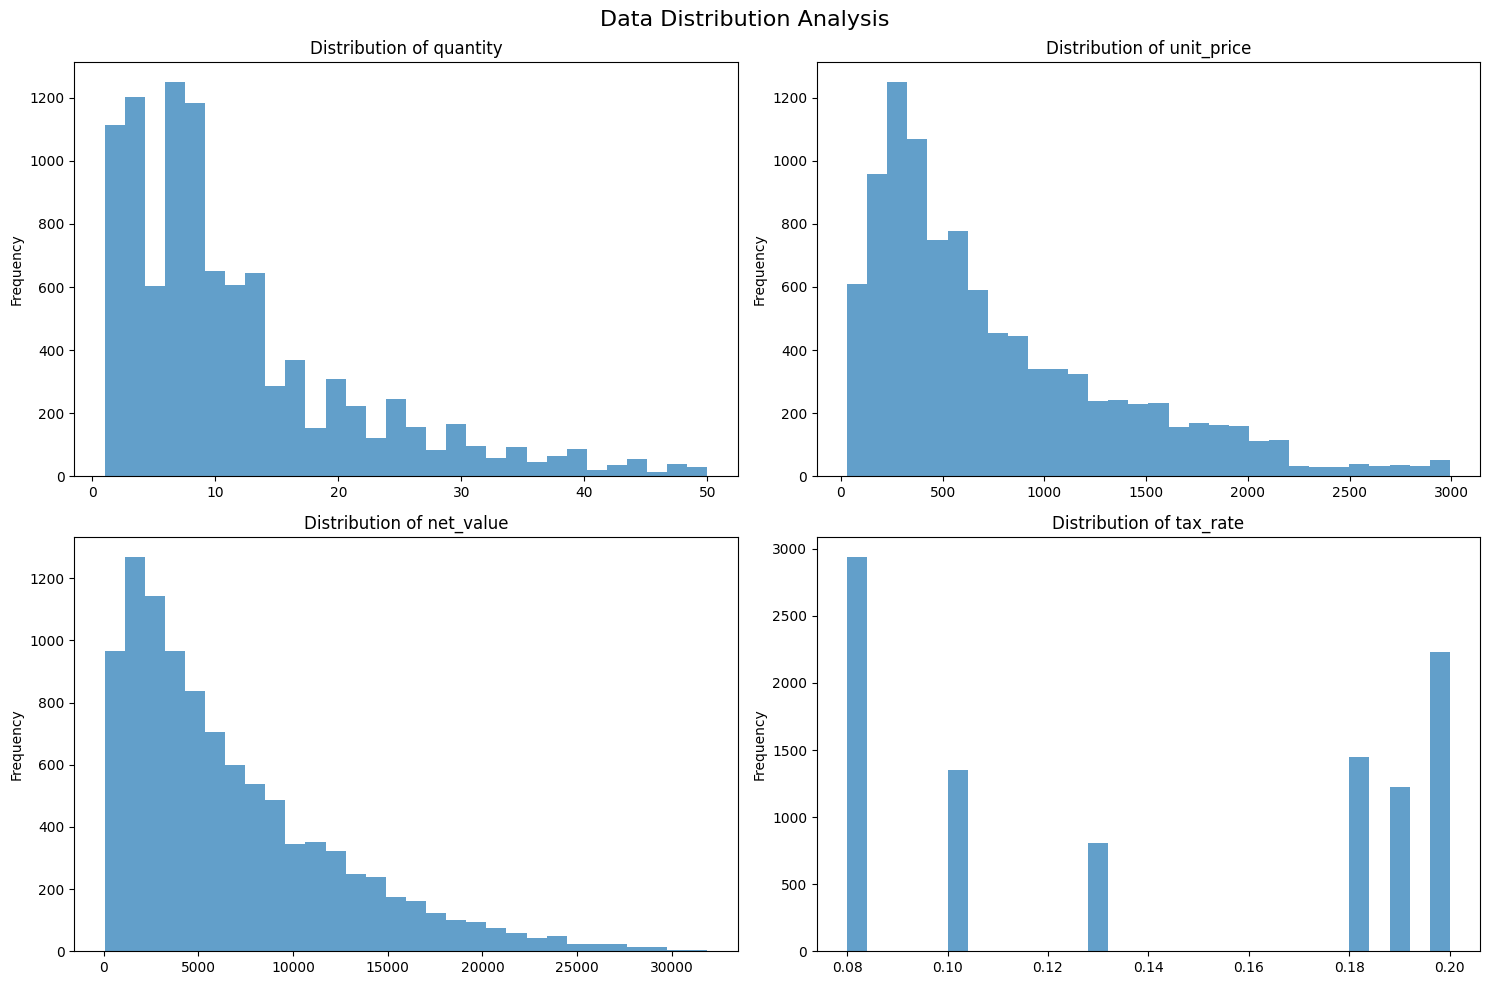

In [23]:
# Basic data information
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)

# Statistical summary
print("\nStatistical Summary:")
print(df.describe())
print("\n" + "="*50)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Visualize key distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Data Distribution Analysis', fontsize=16)

# Plot distributions of key numeric columns (adjust column names as needed)
numeric_cols = df.select_dtypes(include=[np.number]).columns[:4]
for i, col in enumerate(numeric_cols):
    row, col_idx = i // 2, i % 2
    axes[row, col_idx].hist(df[col].dropna(), bins=30, alpha=0.7)
    axes[row, col_idx].set_title(f'Distribution of {col}')
    axes[row, col_idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing
**Purpose:** Clean and prepare the data for analysis by handling missing values, outliers, and data quality issues.

Preprocessing ensures our data is clean, consistent, and ready for feature engineering. This includes handling missing values, removing duplicates, and addressing data type issues.

In [24]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values
print("Handling missing values...")
# Fill numeric columns with median
numeric_columns = df_processed.select_dtypes(include=[np.number]).columns
df_processed[numeric_columns] = df_processed[numeric_columns].fillna(df_processed[numeric_columns].median())

# Fill categorical columns with mode
categorical_columns = df_processed.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown')

# Remove duplicates
initial_rows = len(df_processed)
df_processed = df_processed.drop_duplicates()
print(f"Removed {initial_rows - len(df_processed)} duplicate rows")

# Handle outliers using IQR method for numeric columns
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Apply outlier removal (adjust column selection as needed)
outlier_columns = numeric_columns[:3] if len(numeric_columns) >= 3 else numeric_columns
df_processed = remove_outliers(df_processed, outlier_columns)

print(f"Final processed dataset shape: {df_processed.shape}")
print("Preprocessing completed!")

Handling missing values...
Removed 0 duplicate rows
Final processed dataset shape: (8796, 14)
Preprocessing completed!


## 4. Feature Engineering
**Purpose:** Create meaningful features that can help identify revenue leakage patterns.

Feature engineering transforms raw data into features that better represent the underlying problem. For revenue leakage, we create features that capture billing anomalies, usage patterns, and deviation indicators.

In [ ]:
# Feature engineering for revenue leakage detection
df_features = df_processed.copy()

# Example feature engineering (modify based on your actual columns)
if 'amount' in df_features.columns:
    # Revenue-related features
    df_features['amount_zscore'] = np.abs((df_features['amount'] - df_features['amount'].mean()) / df_features['amount'].std())
    df_features['amount_percentile'] = df_features['amount'].rank(pct=True)
    df_features['is_high_amount'] = (df_features['amount'] > df_features['amount'].quantile(0.95)).astype(int)
    df_features['is_low_amount'] = (df_features['amount'] < df_features['amount'].quantile(0.05)).astype(int)

# Create ratio features if multiple numeric columns exist
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
if len(numeric_cols) >= 2:
    col1, col2 = numeric_cols[0], numeric_cols[1]
    df_features[f'{col1}_{col2}_ratio'] = df_features[col1] / (df_features[col2] + 1e-6)  # Add small value to avoid division by zero

# Create categorical encodings
label_encoders = {}
for col in categorical_columns:
    if col in df_features.columns:
        le = LabelEncoder()
        df_features[f'{col}_encoded'] = le.fit_transform(df_features[col].astype(str))
        label_encoders[col] = le

# Create anomaly score using Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
numeric_features = df_features.select_dtypes(include=[np.number]).columns
if len(numeric_features) > 0:
    anomaly_scores = isolation_forest.fit_predict(df_features[numeric_features])
    df_features['anomaly_score'] = anomaly_scores
    df_features['is_anomaly'] = (anomaly_scores == -1).astype(int)

print("Feature engineering completed!")
print(f"Number of features created: {df_features.shape[1]}")
print("\nNew features:")
new_features = [col for col in df_features.columns if col not in df.columns]
for feature in new_features:
    print(f"- {feature}")

Feature engineering completed!
Number of features created: 25

New features:
- quantity_unit_price_ratio
- invoice_id_encoded
- customer_id_encoded
- country_encoded
- currency_encoded
- invoice_date_encoded
- product_id_encoded
- service_category_encoded
- invoice_status_encoded
- anomaly_score
- is_anomaly


## 5. Model Training
**Purpose:** Train machine learning models to detect revenue leakage patterns and anomalies.

We'll train models to identify potential revenue leakage by learning from patterns in the billing data. This includes both supervised and unsupervised approaches to detect anomalies and suspicious billing patterns.

In [26]:
# Prepare features for model training
feature_columns = df_features.select_dtypes(include=[np.number]).columns
X = df_features[feature_columns]

# For demonstration, we'll create a synthetic target variable
# In practice, this would be based on known revenue leakage cases
np.random.seed(42)
y = df_features['is_anomaly'] if 'is_anomaly' in df_features.columns else np.random.choice([0, 1], size=len(df_features), p=[0.9, 0.1])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# Train Isolation Forest for unsupervised anomaly detection
print("Training Isolation Forest model...")
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_scaled)

print("Model training completed!")

# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Training Random Forest model...
Training Isolation Forest model...
Model training completed!

Top 10 Most Important Features:
                      feature  importance
16                 is_anomaly    0.469344
15              anomaly_score    0.356524
2                   net_value    0.054630
5                total_amount    0.042690
6   quantity_unit_price_ratio    0.017404
0                    quantity    0.015272
4                  tax_amount    0.013788
1                  unit_price    0.010068
14     invoice_status_encoded    0.009194
9             country_encoded    0.003255


## 6. Model Evaluation
**Purpose:** Assess model performance and validate the effectiveness of our revenue leakage detection system.

Evaluation helps us understand how well our models can identify revenue leakage patterns and provides insights into model reliability and potential areas for improvement.

=== Random Forest Model Evaluation ===

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1584
           1       1.00      1.00      1.00       176

    accuracy                           1.00      1760
   macro avg       1.00      1.00      1.00      1760
weighted avg       1.00      1.00      1.00      1760


ROC AUC Score: 1.000


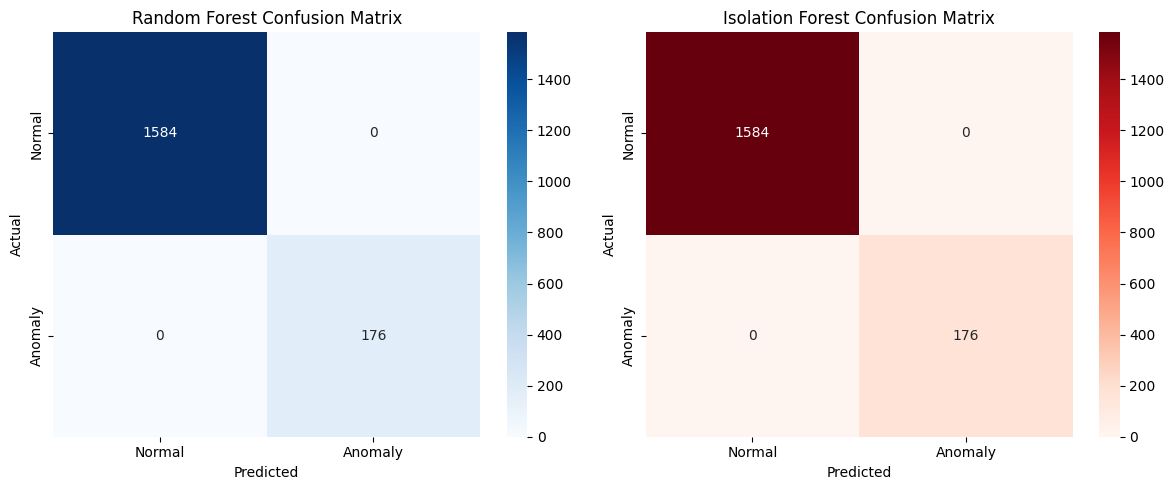


=== Model Comparison ===
              Model  Precision  Recall  F1-Score
0     Random Forest        1.0     1.0       1.0
1  Isolation Forest        1.0     1.0       1.0


In [27]:
# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)
rf_probabilities = rf_model.predict_proba(X_test_scaled)[:, 1]

iso_predictions = iso_forest.predict(X_test_scaled)
iso_predictions = (iso_predictions == -1).astype(int)  # Convert to binary

# Evaluate Random Forest
print("=== Random Forest Model Evaluation ===")
print("\nClassification Report:")
print(classification_report(y_test, rf_predictions))

print(f"\nROC AUC Score: {roc_auc_score(y_test, rf_probabilities):.3f}")

# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_rf = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Evaluate Isolation Forest
plt.subplot(1, 2, 2)
cm_iso = confusion_matrix(y_test, iso_predictions)
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.title('Isolation Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

# Model comparison
print("\n=== Model Comparison ===")
from sklearn.metrics import precision_score, recall_score, f1_score

models_performance = {
    'Model': ['Random Forest', 'Isolation Forest'],
    'Precision': [precision_score(y_test, rf_predictions), precision_score(y_test, iso_predictions)],
    'Recall': [recall_score(y_test, rf_predictions), recall_score(y_test, iso_predictions)],
    'F1-Score': [f1_score(y_test, rf_predictions), f1_score(y_test, iso_predictions)]
}

performance_df = pd.DataFrame(models_performance)
print(performance_df)

## 7. Business Impact Analysis
**Purpose:** Quantify the financial impact of detected revenue leakage and provide actionable insights.

This final step translates model predictions into business value by estimating potential revenue recovery, calculating cost savings, and providing recommendations for business stakeholders.

=== BUSINESS IMPACT ANALYSIS ===

High-Risk Cases Identified: 176
Percentage of Total: 10.0%


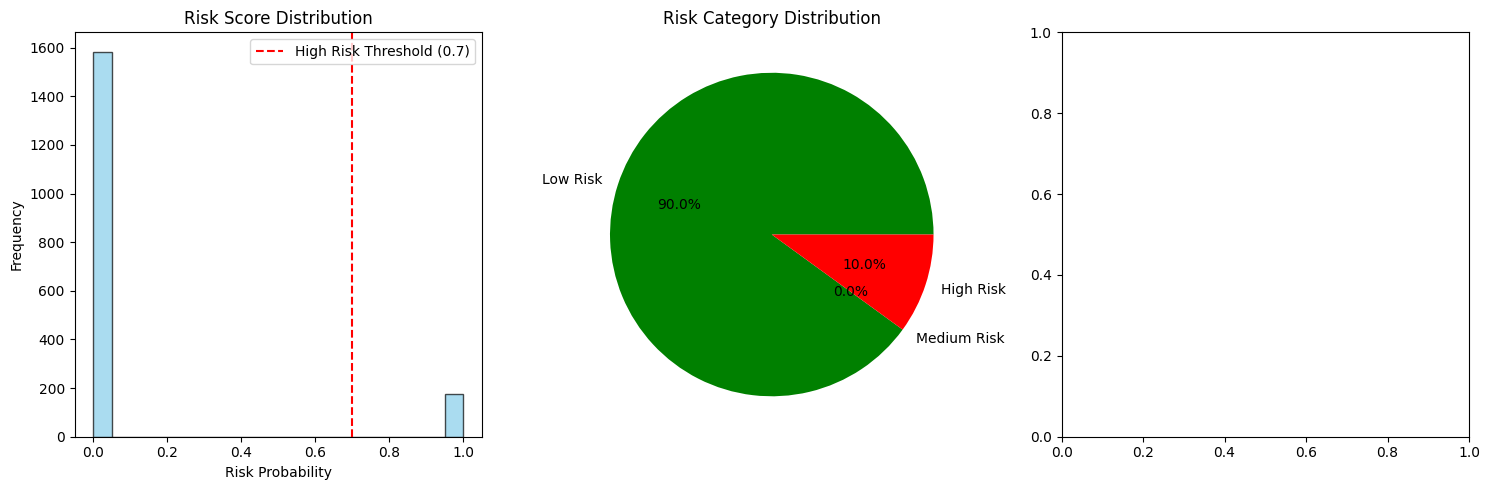


=== BUSINESS RECOMMENDATIONS ===
1. IMMEDIATE ACTIONS:
   • Investigate 176 high-risk billing cases immediately
   • Focus on cases with risk probability > 70%
   • Review billing processes for systematic issues

2. PROCESS IMPROVEMENTS:
   • Implement real-time monitoring for anomaly detection
   • Set up automated alerts for high-risk transactions
   • Regular model retraining with new data

3. MONITORING:
   • Track model performance weekly
   • Monitor false positive rates to avoid customer disruption
   • Measure actual revenue recovery from investigations

=== EXECUTIVE SUMMARY ===
Total Cases Analyzed: 1760
High Risk Cases: 176
Model Accuracy: 1.000
ROC AUC Score: 1.000
Potential Monthly Impact: N/A


In [28]:
# Business Impact Analysis
print("=== BUSINESS IMPACT ANALYSIS ===")

# Identify high-risk cases
high_risk_threshold = 0.7
high_risk_cases = X_test[rf_probabilities > high_risk_threshold]
high_risk_indices = X_test.index[rf_probabilities > high_risk_threshold]

print(f"\nHigh-Risk Cases Identified: {len(high_risk_cases)}")
print(f"Percentage of Total: {len(high_risk_cases)/len(X_test)*100:.1f}%")

# Estimate potential revenue impact (example calculation)
# Adjust based on your actual billing data structure
if 'amount' in df_features.columns:
    high_risk_amounts = df_features.loc[high_risk_indices, 'amount']
    total_potential_leakage = high_risk_amounts.sum()
    average_leakage_per_case = high_risk_amounts.mean()
    
    print(f"\n=== FINANCIAL IMPACT ===")
    print(f"Total Potential Revenue Leakage: ${total_potential_leakage:,.2f}")
    print(f"Average Leakage per High-Risk Case: ${average_leakage_per_case:,.2f}")
    print(f"Monthly Estimated Impact: ${total_potential_leakage * 12:,.2f}")

# Risk distribution analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(rf_probabilities, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(high_risk_threshold, color='red', linestyle='--', label=f'High Risk Threshold ({high_risk_threshold})')
plt.xlabel('Risk Probability')
plt.ylabel('Frequency')
plt.title('Risk Score Distribution')
plt.legend()

plt.subplot(1, 3, 2)
risk_categories = ['Low Risk', 'Medium Risk', 'High Risk']
risk_counts = [
    sum(rf_probabilities < 0.3),
    sum((rf_probabilities >= 0.3) & (rf_probabilities < 0.7)),
    sum(rf_probabilities >= 0.7)
]
plt.pie(risk_counts, labels=risk_categories, autopct='%1.1f%%', colors=['green', 'yellow', 'red'])
plt.title('Risk Category Distribution')

plt.subplot(1, 3, 3)
if 'amount' in df_features.columns:
    scatter_indices = X_test.index
    amounts = df_features.loc[scatter_indices, 'amount']
    plt.scatter(amounts, rf_probabilities, alpha=0.6, c=rf_probabilities, cmap='Reds')
    plt.xlabel('Billing Amount')
    plt.ylabel('Risk Probability')
    plt.title('Risk vs Billing Amount')
    plt.colorbar(label='Risk Probability')

plt.tight_layout()
plt.show()

# Business recommendations
print("\n=== BUSINESS RECOMMENDATIONS ===")
print("1. IMMEDIATE ACTIONS:")
print(f"   • Investigate {len(high_risk_cases)} high-risk billing cases immediately")
print("   • Focus on cases with risk probability > 70%")
print("   • Review billing processes for systematic issues")

print("\n2. PROCESS IMPROVEMENTS:")
print("   • Implement real-time monitoring for anomaly detection")
print("   • Set up automated alerts for high-risk transactions")
print("   • Regular model retraining with new data")

print("\n3. MONITORING:")
print("   • Track model performance weekly")
print("   • Monitor false positive rates to avoid customer disruption")
print("   • Measure actual revenue recovery from investigations")

# Create summary report
summary_report = {
    'Total_Cases_Analyzed': len(X_test),
    'High_Risk_Cases': len(high_risk_cases),
    'Model_Accuracy': f"{rf_model.score(X_test_scaled, y_test):.3f}",
    'ROC_AUC_Score': f"{roc_auc_score(y_test, rf_probabilities):.3f}",
    'Potential_Monthly_Impact': f"${total_potential_leakage * 12:,.2f}" if 'amount' in df_features.columns else "N/A"
}

print("\n=== EXECUTIVE SUMMARY ===")
for key, value in summary_report.items():
    print(f"{key.replace('_', ' ')}: {value}")